# Mujoco Manipulation Tasks

This files includes several manipulation task with mujoco.

The code is based on a tutorial by Kevin Zakka: https://github.com/kevinzakka/mjctrl

and the manipulation tutorial by Russ Tedrake: https://manipulation.mit.edu/

In [1]:
import mujoco
import mediapy as media
import numpy as np

## Load the model

""

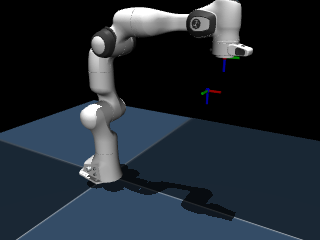

In [2]:
# Select the robot arm type, ur5e or panda
# robot_name = "ur5e"
robot_name = "panda"

if robot_name == "ur5e":
    xml_path = "robot/robot_arms/universal_robots_ur5e/scene.xml"
else:
    xml_path = "robot/robot_arms/franka_emika_panda/scene.xml"

model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)

# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, 0)

renderer = mujoco.Renderer(model)
scene_option = mujoco.MjvOption()
scene_option.frame = mujoco.mjtFrame.mjFRAME_SITE
# Make all sitegroup visiable 
scene_option.sitegroup[4] = 1

mujoco.mj_forward(model, data)
renderer.update_scene(data, scene_option=scene_option)
media.show_image(renderer.render())

# Target_id
mocap_id = model.body("target").mocapid[0]
# End-effector site we wish to control, in this case a site attached to the last
# link (wrist_3_link) of the robot.
site_id = model.site("attachment_site").id

## Define target trajectory

In [3]:
# Circle radius
r = 0.15
# Circle center x coordinates
cx = 0.5
# Circle centeer y cooridnates
cy = 0.0
# Trajectory freq
f = 0.5

def circle(t: float, r: float, h: float, k: float, f: float) -> np.ndarray:
    """Return the (x, y) coordinates of a circle with radius r centered at (h, k)
    as a function of time t and frequency f."""
    x = r * np.cos(2 * np.pi * f * t) + h
    y = r * np.sin(2 * np.pi * f * t) + k
    return np.array([x, y])

## Visualization helper

In [4]:
def add_visual_capsule(scene, point1, point2, radius, rgba):
    """Adds one capsule to an mjvScene."""
    if scene.ngeom >= scene.maxgeom:
        return
    scene.ngeom += 1  # increment ngeom
    # initialise a new capsule, add it to the scene using mjv_makeConnector
    mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                        mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                        np.zeros(3), np.zeros(9), rgba.astype(np.float32))
    mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                            mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                            point1[0], point1[1], point1[2],
                            point2[0], point2[1], point2[2])
  
def modify_scene(scn, target_traj, end_effector_traj):
    """Draw position trace"""
    if len(target_traj) > 1:
        for i in range(len(target_traj)-1):
            add_visual_capsule(scn, target_traj[i], target_traj[i+1], 0.005, np.array([0, 0, 1.0, 1.0]))
            add_visual_capsule(scn, end_effector_traj[i], end_effector_traj[i+1], 0.005, np.array([1.0, 0, 0, 0.8]))

## Simulate without controls

In [5]:
duration = 5 # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
end_effector_traj = []
target_traj = []

# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, 0)

while data.time < duration:

    # Set the target position accordingly
    data.mocap_pos[mocap_id, 0:2] = circle(data.time, r, cx, cy, f)
    mujoco.mj_step(model, data)

    # Updates the trajs
    target_traj.append(data.mocap_pos[mocap_id].copy())
    end_effector_traj.append(data.site(site_id).xpos.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="end_effector_camera", scene_option=scene_option)
        # Draw trajs
        modify_scene(renderer.scene, target_traj, end_effector_traj)
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate)

## 

## Simulate with a controller that follows the target

We implement this simply through the differential inverse kinematics

In [6]:
duration = 8 # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
ee_view_frames = []
end_effector_traj = []
target_traj = []

# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, 0)

 # Pre-allocate numpy arrays.
jac = np.zeros((6, model.nv))
error = np.zeros(6)
error_pos = error[:3]
error_ori = error[3:]
site_quat = np.zeros(4)
target_quat_conj = np.zeros(4)
error_quat = np.zeros(4)

while data.time < duration:
    
    # Set the target position accordingly
    data.mocap_pos[mocap_id, 0:2] = circle(data.time, r, cx, cy, f)

    # We now want to track the target position with a simple inverse IK.

    # Get the pos error in the world frame
    # Here we update the numerical value using error_pos[:], so the error[:3] will also change accordingly 
    error_pos[:] = data.site(site_id).xpos - data.mocap_pos[mocap_id]
    
    # Get the orientation error
    # Recall we have target_ori \times error_ori = ee_ori, so the error_ori = ee_ori \times inverse(target_ori)
    # Most mujoco embed function for orientation is quaternion based, alternative way is use scipy/jax lie etc.
    target_ori = data.mocap_quat[mocap_id]
    mujoco.mju_negQuat(target_quat_conj, target_ori)
    mujoco.mju_mat2Quat(site_quat, data.site(site_id).xmat)
    mujoco.mju_mulQuat(error_quat, site_quat, target_quat_conj)
    # Convert error quaternion to axis-angle representation
    # We do so, as the Jacobian function we will use represent orientation error in axis-angle form
    mujoco.mju_quat2Vel(error_ori, error_quat, 1.0)
    
    # Get the Jacobian with respect to the end-effector site.
    # This function calculate the Jacobian of the world coordinates of a body frame
    mujoco.mj_jacSite(model, data, jac[:3], jac[3:], site_id)

    # Solve the differential IK
    # We want to have the error equal to zero
    # We take a step dq such J dq = -error 
    # Note, the origin differential IK works on J v = -speed * error / dt
    # Here we implement a simple version by using dq and making Jdq = -error.
    dq = np.linalg.pinv(jac) @ -error

    # Our robot arm is position controlled, so we simple give it the target joint configure
    q = data.qpos.copy()
    # Add dq to q, here results should be the same as q = q + dq. It is different when q includes quaternian
    mujoco.mj_integratePos(model, q, dq, 1)
    
    # Our robot is configured to be position control
    # Here we direct set the control signal to the desired position
    np.clip(q, *model.jnt_range.T, out=q)
    data.ctrl = q

    # Step the simulation.
    mujoco.mj_step(model, data)

    # Updates the trajs
    target_traj.append(data.mocap_pos[mocap_id].copy())
    end_effector_traj.append(data.site(site_id).xpos.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        modify_scene(renderer.scene, target_traj[::10], end_effector_traj[::10])
        pixels = renderer.render()
        frames.append(pixels)

        renderer.update_scene(data, camera="end_effector_camera", scene_option=scene_option)
        modify_scene(renderer.scene, target_traj[::10], end_effector_traj[::10])
        pixels = renderer.render()
        ee_view_frames.append(pixels)

media.show_video(frames, fps=framerate)
media.show_video(ee_view_frames, fps=framerate)

## Differential IK with configuration(null space!) preference

There are many possible robots configurations that follow the desired trajectory due to many degree of freedom of our robot.

In the below section, we want to specified preferences such that our robot not only follows the desired trajectory but also try to find configuration that match our preference as much as possible


In [7]:
# Here we want our robot not only follow the desired pose but also be as close to its initial configuration as possible 
q0 = model.key(0).qpos

# Gain the importance of each joints to match initial configuration.
if robot_name == "ur5e":
    Kn = np.diag(np.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0]))
else:
    Kn = np.diag(np.array([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]))

duration = 8
framerate = 30  
frames = []
ee_view_frames = []
end_effector_traj = []
target_traj = []
mujoco.mj_resetDataKeyframe(model, data, 0)

while data.time < duration:
    
    # Same as previous section
    data.mocap_pos[mocap_id, 0:2] = circle(data.time, r, cx, cy, f)
    error_pos[:] = data.site(site_id).xpos - data.mocap_pos[mocap_id]
    target_ori = data.mocap_quat[mocap_id]
    mujoco.mju_negQuat(target_quat_conj, target_ori)
    mujoco.mju_mat2Quat(site_quat, data.site(site_id).xmat)
    mujoco.mju_mulQuat(error_quat, site_quat, target_quat_conj)
    mujoco.mju_quat2Vel(error_ori, error_quat, 1.0)
    mujoco.mj_jacSite(model, data, jac[:3], jac[3:], site_id)

    # Solve the differential IK
    # We take a step dq such J dq = -error
    # Unlike previous section where we directly multiply the "inverse" of Jacobian to obtain the solution, which resulting in the minimum norm dq,
    # here we solve the dq through optimization:
    # min \|Kn (q + dq - q_0) \|_2^2
    # s.t. J dq = -error 
    # We can apply KKT condition to solve this optimization problem analytically.
    
    q = data.qpos.copy()
    # Construct KKT matrix
    KKT_matrix = np.concatenate([
        np.concatenate([2 * Kn.T @ Kn, jac.T], axis=1),
        np.concatenate([jac, np.zeros((jac.shape[0], jac.shape[0]))], axis=1)
        ], axis=0)
    dq = (np.linalg.pinv(KKT_matrix) @ np.concatenate([2 * Kn.T @ Kn @ (q0 -  q), -error]))[:q.shape[0]]

    mujoco.mj_integratePos(model, q, dq, 1)
    np.clip(q, *model.jnt_range.T, out=q)
    data.ctrl = q

    mujoco.mj_step(model, data)

    target_traj.append(data.mocap_pos[mocap_id].copy())
    end_effector_traj.append(data.site(site_id).xpos.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        modify_scene(renderer.scene, target_traj[::10], end_effector_traj[::10])
        pixels = renderer.render()
        frames.append(pixels)

        renderer.update_scene(data, camera="end_effector_camera", scene_option=scene_option)
        modify_scene(renderer.scene, target_traj[::10], end_effector_traj[::10])
        pixels = renderer.render()
        ee_view_frames.append(pixels)

media.show_video(frames, fps=framerate)
media.show_video(ee_view_frames, fps=framerate)

## Operational space control (Torque controll!)
So far, the algorithms we implemented works only for kinematics i.e. we solve the desired joint position, and use a PID controller to track the desired joint position through robot configuration xml.

In the below section, we want to try something by directly command the torque to the robot instead of position command. We implement this through operational space control (OSC)

Given a target pose: $x_\text{target}$, we want to our end-effector to have desired acceleration: $\ddot{x}_\text{des} = -K_p(x - x_\text{target}) - K_v (\dot{x})$.

Now, we want to use OSC to command torque such that the acceleration of end-effector mathces $\ddot{x}_\text{des}$.
By ignoring some terms (namely terms involving $\dot{J} \dot{q}$), we have the desired toque command:
$$\tau = J^T M_x \ddot{x}_\text{des} + \text{bias},$$
where bias contains the gravity and coriolis force, and $M_x = (J M^{-1} J^T)^{-1}$

""

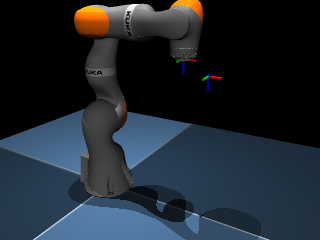

In [12]:
# Delete previous render to avoid visualization issue 
try:
  del renderer
except:
  pass

# Load the kuka robot
model = mujoco.MjModel.from_xml_path("robot/robot_arms/kuka_iiwa_14/scene.xml")
data = mujoco.MjData(model)

# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, 0)

renderer = mujoco.Renderer(model)
scene_option = mujoco.MjvOption()
scene_option.frame = mujoco.mjtFrame.mjFRAME_SITE
# Make all sitegroup visiable 
scene_option.sitegroup[4] = 1

mujoco.mj_forward(model, data)
renderer.update_scene(data, scene_option=scene_option)
media.show_image(renderer.render())

# Target_id
mocap_id = model.body("target").mocapid[0]
# End-effector site we wish to control, in this case a site attached to the last
# link (wrist_3_link) of the robot.
site_id = model.site("attachment_site").id

In [26]:
frames = []
target_traj = []
end_effector_traj = []
duration = 8
framerate = 30 

# Pre-allocate numpy arrays.
M_inv = np.zeros((model.nv, model.nv))
Mx = np.zeros((6, 6))
jac = np.zeros((6, model.nv))
error = np.zeros(6)
error_pos = error[:3]
error_ori = error[3:]
site_quat = np.zeros(4)
target_quat_conj = np.zeros(4)
error_quat = np.zeros(4)

# Construct Kp
# Cartesian impedance control gains.
impedance_pos = np.asarray([100.0, 100.0, 100.0])  # [N/m]
impedance_ori = np.asarray([50.0, 50.0, 50.0])  # [Nm/rad]
Kp = np.concatenate([impedance_pos, impedance_ori], axis=0)
# Construct Kd through damping ratio.
damping_ratio = 1.0
damping_pos = damping_ratio * 2 * np.sqrt(impedance_pos)
damping_ori = damping_ratio * 2 * np.sqrt(impedance_ori)
Kd = np.concatenate([damping_pos, damping_ori], axis=0)

# Define null space preference
q0 = model.key(0).qpos
Kp_null = np.asarray([75.0, 75.0, 50.0, 50.0, 40.0, 25.0, 25.0])
Kd_null = damping_ratio * 2 * np.sqrt(Kp_null)

mujoco.mj_resetDataKeyframe(model, data, 0)
while data.time < duration:
    data.mocap_pos[mocap_id, 0:2] = circle(data.time, r, cx, cy, f)
    error_pos[:] = data.site(site_id).xpos - data.mocap_pos[mocap_id]
    target_ori = data.mocap_quat[mocap_id]
    mujoco.mju_negQuat(target_quat_conj, target_ori)
    mujoco.mju_mat2Quat(site_quat, data.site(site_id).xmat)
    mujoco.mju_mulQuat(error_quat, site_quat, target_quat_conj)
    mujoco.mju_quat2Vel(error_ori, error_quat, 1.0)
    mujoco.mj_jacSite(model, data, jac[:3], jac[3:], site_id)

    # Compute the task-space inertia matrix.
    # The below function solve: Mx = y, where x is the return stored in "M_inv" and y is "np.eye(model.nv)", here we explicity solve for M^{-1}
    mujoco.mj_solveM(model, data, M_inv, np.eye(model.nv))
    Mx_inv = jac @ M_inv @ jac.T
    Mx = np.linalg.pinv(Mx_inv)

    # Compute generalized forces.
    tau = jac.T @ Mx @ (-Kp * error - Kd * (jac @ data.qvel)) + data.qfrc_bias

    # Add null space preference
    Jbar = M_inv @ jac.T @ Mx
    ddq = -Kp_null * (data.qpos-q0) - Kd_null * data.qvel
    tau += (np.eye(model.nv) - jac.T @ Jbar.T) @ ddq

    # Set the control signal and step the simulation.
    np.clip(tau, *model.actuator_ctrlrange.T, out=tau)
    data.ctrl = tau
    mujoco.mj_step(model, data)

    target_traj.append(data.mocap_pos[mocap_id].copy())
    end_effector_traj.append(data.site(site_id).xpos.copy())

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        modify_scene(renderer.scene, target_traj[::10], end_effector_traj[::10])
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)